In [1]:
# https://github.com/alexliyang/Keras-Tiramisu/blob/master/model.py # carga los pesos de las clases con pickle
# https://github.com/xxmarl/100-tiramisu-keras # variables de una letra xd

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.regularizers import l2
from keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization, 
    Dropout, AveragePooling2D, MaxPooling2D, Concatenate, Activation
)

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
allow_growth_session = tf.Session(config=config)
tf.keras.backend.set_session(allow_growth_session)

Using TensorFlow backend.


Layer:
Batch Normalization -> ReLU -> 3 × 3 Convolution -> Dropout p = 0.2

TD:
Batch Normalization -> ReLU -> 1 × 1 Convolution -> Dropout p = 0.2 -> 2 × 2 Max Pooling

TU:
3 × 3 Transposed Conv stride = 2

In [2]:
def imread(fname, size=(400, 640)):
    im = cv2.imread(fname)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, size, interpolation=cv2.INTER_AREA)
    return im

In [3]:
def denseLayer(x, filters, dropout_p=0.2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(
        filters, kernel_size=(3, 3), padding='same',
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4) # usa lecun_normal
    )(x)
    x = Dropout(dropout_p)(x)
    return x

def denseBlock(x, n_layers, growth_rate, dropout_p):
    new_features = []
    
    for i in range(n_layers):
        layer = denseLayer(x, growth_rate, dropout_p)
        new_features.append(layer)
        x = Concatenate()([x, layer])
        # x = Concatenate()([x, denseLayer(x, growth_rate)])
    new_features = Concatenate()(new_features)
    
    return x, new_features

def TD(x, n_filters, dropout_p=0.2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(
        n_filters, kernel_size=(1, 1), padding='same',
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)
    )(x)
    x = Dropout(dropout_p)(x)
    # x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x

def TU(x, skip_connection, n_filters):
    x = Conv2DTranspose(
        n_filters, kernel_size=(3, 3), padding='same', strides=(2, 2),
        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)
    )(x)
    x = Concatenate()([x, skip_connection])
    return x

In [4]:
def build(width, height, n_classes, n_filters_first_conv=48, dropout_p=0.2):
    # inputs, num_classes, n_filters_first_conv=48, 
    # n_pool=5, growth_rate=12, n_layers_per_block=4, dropout_p=0.2, scope=None
    input = Input(shape=(height, width, 3))
    
    n_pool=4
    growth_rate=6
    n_layers_per_block=3
    n_filters = n_filters_first_conv
    n_layers_per_block = [n_layers_per_block] * (2 * n_pool + 1)
    
    # first conv
    stack = Conv2D(
        n_filters_first_conv, kernel_size=(3, 3), padding='same', 
        kernel_initializer='he_normal', name='first_conv'
    )(input)
    
    # downsampling
    skip_connection_list = []
    
    for i in range(n_pool):
        # denseBlock
        stack, _ = denseBlock(stack, n_layers_per_block[i], growth_rate, dropout_p)
        n_filters += growth_rate * n_layers_per_block[i]
        skip_connection_list.append(stack)
        
        # transition down
        stack = TD(stack, n_filters, dropout_p)
    
    skip_connection_list = skip_connection_list[::-1]
    
    # bottleneck
    stack, block_to_upsample = denseBlock(stack, n_layers_per_block[n_pool], growth_rate, dropout_p)
    
    # upsampling
    for i in range(n_pool):
        # transition up (upsampling + concatenation with the skip connection)
        n_filters_keep = growth_rate * n_layers_per_block[n_pool + i]
        stack = TU(block_to_upsample, skip_connection_list[i], n_filters_keep)
        
        # denseBlock
        stack, block_to_upsample = denseBlock(stack, n_layers_per_block[n_pool + i + 1], growth_rate, dropout_p)
        
    # softmax
    output = Conv2D(n_classes, kernel_size=(1, 1), activation='softmax')(stack)
    # output = Activation('softmax')(output)
    
    model = Model(inputs=input, outputs=output)
    
    return model

In [5]:
model = build(400, 640, 4)










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [6]:
model.count_params()

211462

In [7]:
im = imread('choppy.png')
im = np.expand_dims(im, axis=0)

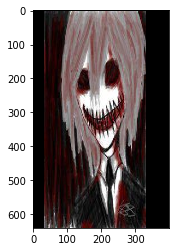

In [8]:
plt.imshow(im[0])

In [9]:
res = model.predict(im)

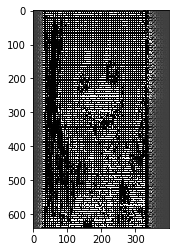

In [10]:
plt.imshow(res[0, ..., 3], cmap='gray')

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [12]:
# crear generadores de small_opends y ver si la wea entrena v:

In [13]:
import os
import glob
import numpy as np
import skimage.io as io
from utils import utils, helpers

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, folder, set_folder='train', batch_size=32, dim=(640,400), n_channels=3, n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.folder = folder
        self.images = self.get_files(set_folder)
        self.labels = self.get_files(set_folder+'_labels')
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # im_indexes = self.images[indexes*self.batch_size:(index+1)*self.batch_size]
        # lb_indexes = self.labels[indexes*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.__len__())
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def get_files(self, type_folder):
        return sorted(glob.glob(os.path.join(self.folder, type_folder, '*')))

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), np.uint8)
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=np.uint8)
        # dividir y con to one hot de utils

        # Generate data
        for i, idx in enumerate(indexes):
            # Store sample
            X[i,] = utils.load_image(self.images[idx])
            lb = np.load(self.labels[idx])
            for x in np.unique(lb):
                y[i,...,x] = np.where(lb == x, 1, 0)

        return X, y

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [14]:
trainG = DataGenerator('openeds_split', 'train', 2)
testG = DataGenerator('openeds_split', 'test', 2)
valG = DataGenerator('openeds_split', 'val', 2)

print(len(trainG) + len(testG) + len(valG))

11319


In [17]:
opt = keras.optimizers.SGD(lr=1e-3)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(generator=trainG, validation_data=valG, steps_per_epoch=len(trainG)//2)

Epoch 1/1
 454/3395 [===>..........................] - ETA: 11:53 - loss: 16.0845 - acc: 0.0118

KeyboardInterrupt: 

In [ ]:
plt.plot(range(100), range(100), label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
plt.plot(range(3), [1, 2, 3], label="test1")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
